# Model

In [272]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

from sklearn.metrics import log_loss

class TSTrendDetection():
    def __init__(self, bandwidth = 1.0):
        self.bandwidth = bandwidth
        self.mean_shift = MeanShift(bandwidth = self.bandwidth)
        self.scaler = StandardScaler()

    def fit_mean_shift(self, X):
        """
        Mean Shift model fitting.

        Parameters
        ----------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples timedelta from first sample
            second samples values
        or
        X: pd.DataFrame:
            has column timedelta from first sample
            has column value

        Returns
        -------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples time
            second samples values
        labels: np.ndarray:
            np.ndarray (shape = (samples_count,))
        clustered_ts_value: list:
            list of np.ndarray of clustered values
        clustered_ts_time: list:
            list of np.ndarray of clustered times
        clustered_ts_cofs: list:
            list of slopes of linear regression
        clustered_ts_intercepts: list:
            list of intercepts of linear regression
        """
        X = X.copy()

        if isinstance(X, pd.DataFrame):
            X.time = X.time.dt.total_seconds()
            X = X[['time', 'value']].values
        if not isinstance(X, np.ndarray):
            raise ValueError("X must be np.ndarray or pd.DataFrame.")

        # Scaling ts data
        scaler = self.scaler
        X_scaled = scaler.fit_transform(X)

        # Clustering ts data
        self.mean_shift.fit(X_scaled)
        labels = self.mean_shift.labels_

        # Linear regressions for clustered data
        clusters = np.unique(labels)

        clustered_ts_values = []
        clustered_ts_times = []
        clustered_ts_cofs = []
        clustered_ts_intercepts = []

        for cluster in clusters:
            clustered_series = X[np.where(labels == cluster)]

            times, values, cof, intercept = self._fit_linear_regression(
                clustered_series)

            clustered_ts_values.append(values)
            clustered_ts_times.append(times)
            clustered_ts_cofs.append(cof[0])
            clustered_ts_intercepts.append(intercept)

        return (X, labels, clustered_ts_times, clustered_ts_values,
                clustered_ts_cofs, clustered_ts_intercepts)

    def _fit_linear_regression(self, clustered_series):
        """fit_linear_regression
        Parameters
        ----------
        clustered_series: np.ndarray (shape = (samples of cluster, 2)) :
            first samples time
            second samples values

        Returns
        -------
        X: np.ndarray (shape = (samples_count, 2)) :
            first samples time
            second samples values
        clustered_ts_value: np.ndarray:
            np.ndarray of clustered values
        clustered_ts_time: np.ndarray:
            np.ndarray of clustered times
        clustered_ts_cofs: float:
            slope of a linear regression
        clustered_ts_intercepts: float:
            intercept of a linear regression
        """
        model = LinearRegression()
        model.fit(clustered_series[:, 0].reshape(-1, 1),
                  clustered_series[:, 1].reshape(-1, 1)
                  )

        clustered_ts_value = model.predict(
            clustered_series[:, 0].reshape(-1, 1)
            )
        clustered_ts_time = clustered_series[:, 0]

        # a - slope of a linear regression
        clustered_ts_cofs = model.coef_[0]

        # b - intercept of a linear regression
        clustered_ts_intercepts = model.intercept_

        return (clustered_ts_time, clustered_ts_value,
                clustered_ts_cofs, clustered_ts_intercepts)

    def predict(self, context, model_input, params=None):
        """
        Prediction method for the custom model.

        Parameters:
        -----------
        context : Any
            Ignored in this example. It's a placeholder for additional data or utility methods.

        model_input : tuple
            The input DataFrame or ndarray classified as normal or has anomaly slope.
            and alpha threshold.

        params : dict, optional
            Additional prediction parameters. Ignored.

        Returns:
        --------
        bool
            Has anomaly TS or not.
        """
        return self._predict_internal(model_input[0], model_input[1])

    def _predict_internal(self, X, alpha):
        """
        Prediction using slopes of linear regressions.
        if true then anomaly detected in time series
        """
        _, _, _, _, clustered_ts_cofs, _ = self.fit_mean_shift(X)
        return (clustered_ts_cofs > alpha).astype(int)


    def downsample(self, X, smoothing_window = None, skip_window = None):
        """
        Method for time series downsampling.

        Parameters:
        -----------
        X : pd.DataFrame
            first column timedelta
            second column float values
        Returns:
        --------
        pd.DataFrame
            downsampled X.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Time series must be a pd.Series.")
        X = X.copy()
        if smoothing_window != None:
            X.value = X.value.rolling(window=smoothing_window,
                                                    min_periods=1).median()

        if (skip_window != None):
            X.index = X.time
            X = X.value.resample(skip_window).median().fillna(0)
            X = pd.DataFrame({'time': X.index, 'value': X.values})
        return X

    def _binary_cross_entropy(self, threshold, slopes, labels):
        """
        binary cross entropy
        ----------
        threshold: float:
            finding best threshold, by optimizing bce
        slopes: list, array:
            list of slopes, used as thresholds
        labels: np.ndarray (shape = (samples of cluster, 2)) :
            labeled anomalies: 1 if anomaly, 0 otherwise
        Returns
        -------
        best_threshold: float:
            threshold corresponding to highest f1 score
        """
        predictions = (slopes > threshold).astype(int)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return log_loss(labels, predictions)

    def evaluate_thresholds(self, slopes, labels):
        """
        A method for finding best threshold using binary cross entropy
        ----------
        slopes: list, array:
            list of slopes of linear regressions,
        labels: np.ndarray (shape = (samples of cluster, 2)) :
            labeled anomalies: 1 if anomaly, 0 otherwise
        Returns
        -------
        best_threshold: float:
            threshold corresponding to best cross entropy result
        """
        if len(slopes) < 2:
          return slopes[0]

        initial_threshold = np.mean(slopes)

        # binary cross entropy minimization
        result = minimize(self._binary_cross_entropy, np.mean(slopes),
                          args=(slopes, labels),
                          bounds=[(min(slopes), max(slopes) + 3*np.std(slopes))])#,
                          #method='Powell')

        if result.success:
            optimal_threshold = result.x[0]
            return optimal_threshold
        raise Exception("Optimization failed")


# Import

In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Uvelka/AnomalyDetection')

In [3]:
DATAPAH = '/content/drive/MyDrive/Colab Notebooks/Uvelka/Data/'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv(DATAPAH + 'concat_data.csv', date_format = "%d/%m/%Y", parse_dates=['Дата/Время'], decimal = ',', dayfirst=True).iloc[:-1 , :]

In [6]:
df_copy = df.copy()

In [7]:
test_data = df_copy[['Дата/Время', 'Токовый ремни Афл3.1.Максим RMS']].copy()#.iloc[19500:20500,:]

In [8]:
df_copy_10_days = test_data.iloc[-864000:,:].reset_index(drop=True).copy()

In [ ]:
# pd.to_datetime(test_data['Дата/Время'], dayfirst=True)

In [9]:
df_copy_10_days['Токовый ремни Афл3.1.Максим RMS'] = \
 df_copy_10_days['Токовый ремни Афл3.1.Максим RMS'].rolling(window=30*60,
                                                            min_periods=1).median()

In [10]:
df_copy_10_days['timedelta'] = pd.to_timedelta(df_copy_10_days.index, unit='s')

# evaluating

Работа модели состоит из 2 этапов.
1. Сегментация данных через метод кластеризации, затем эти сегменты размечает эксперт (1 - аномалия, 0 - норма)  
2. На основе разметки подбирается наиболее подходящий порог отсечения наклона ЛР (линейной регрессии)аномальных наблюдений от нормальных.

In [273]:
model = TSTrendDetection(bandwidth = 1.0)

In [228]:
df_input = pd.DataFrame()

In [229]:
df_input[['time','value']] = df_copy_10_days[['timedelta','Токовый ремни Афл3.1.Максим RMS']].copy()

In [230]:
# Если есть skip_window, то ВР группируется по этому параметру.
# Пример есть 3 наблюдения за 1 минуту (1 min 12 sec: 5) (1 min 36 sec: 7) (1 min 47 sec: 9)
# Три наблюдения группируется в одно (1 min 0 sec: 7)
df_down_sampled = model.downsample(df_input, skip_window = '60s')

<Axes: >

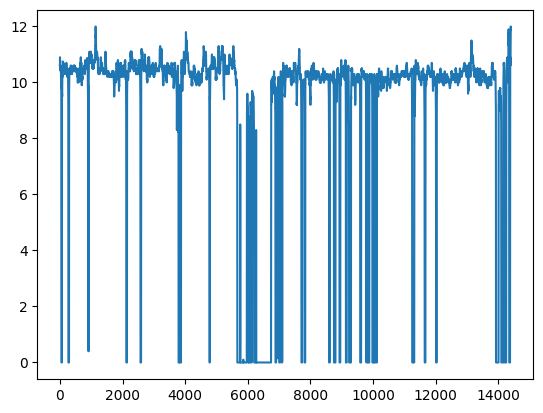

In [231]:
df_down_sampled.value.plot()

Разбитие на 10 частей (10 дней)  
Из них 2 последние тестовые  
8 тренеровочные (2 дня валидационных, 4 фолда)  

In [232]:
df_split = np.array_split(df_down_sampled, 10)

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Реальных данных с аномалиями не предоставили, но есть описание аномалий. Поэтому стоит добавить эти аномалии исскуственно.

К некоторым реальным данным будет добавлен положительный тренд (т.е часть данных станет аномальными)

In [233]:
# Добавление тренда к 0 ряду.
startdate = 700
enddate = 1400
trend = np.linspace(0, 2, num=(enddate-startdate+1))
df_split[0].loc[startdate:enddate, 'value'] = (df_split[0].loc[startdate:enddate, 'value'] + trend)

In [234]:
# Добавление тренда к 1 ряду.
startdate = df_split[1].index[0]
enddate = df_split[1].index[-1]
trend = np.linspace(0, 3, num=(enddate-startdate+1))
df_split[1].loc[startdate:enddate, 'value'] = (df_split[1].loc[startdate:enddate, 'value'] + trend)

In [235]:
# Добавление тренда к 6 ряду.
startdate = 9350
enddate = 9800
trend = np.linspace(0, 3, num=(enddate-startdate+1))
df_split[6].loc[startdate:enddate, 'value'] = (df_split[6].loc[startdate:enddate, 'value'] + trend)

In [236]:
# Добавление тренда к 8 тестовому ряду.
startdate = 12100
enddate = df_split[8].index[-1]
trend = np.linspace(0, 4, num=(enddate-startdate+1))
df_split[8].loc[startdate:enddate, 'value'] = (df_split[8].loc[startdate:enddate, 'value'] + trend)

Участок: 0


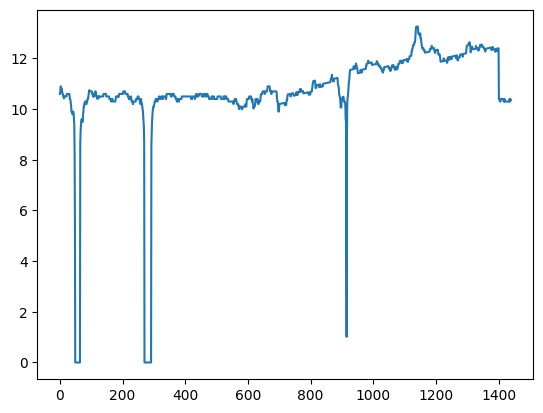



Участок: 1


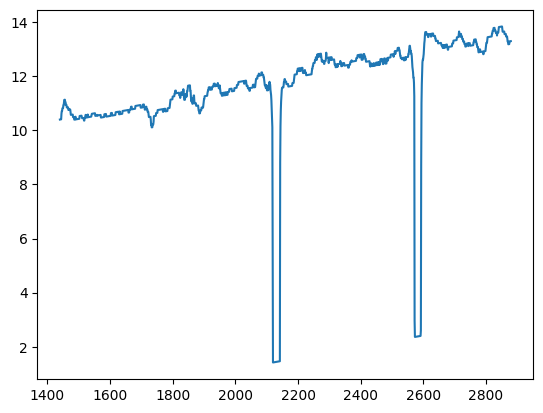



Участок: 2


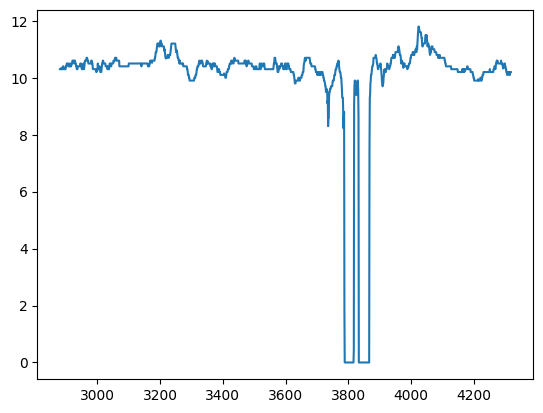



Участок: 3


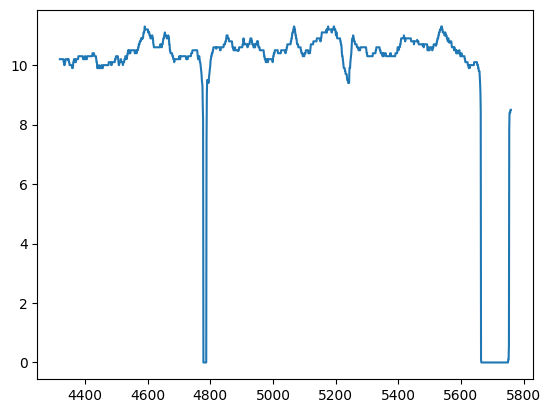



Участок: 4


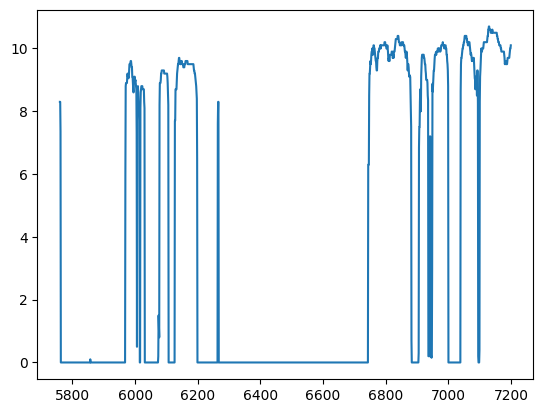



Участок: 5


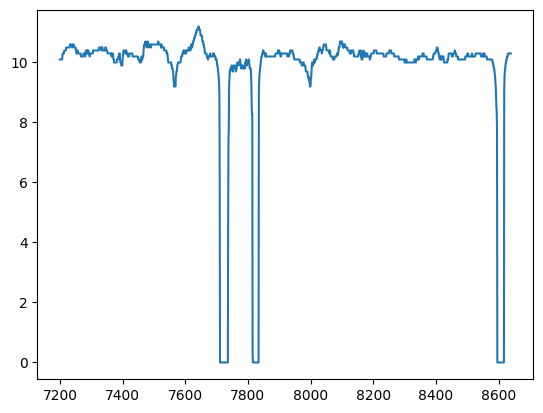



Участок: 6


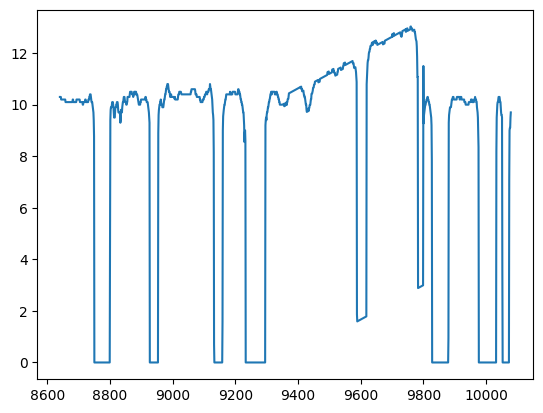



Участок: 7


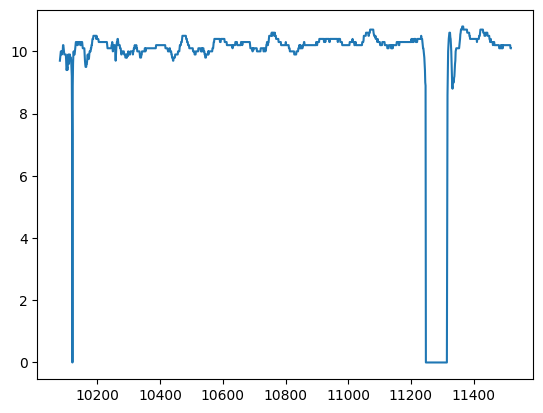



Участок: 8


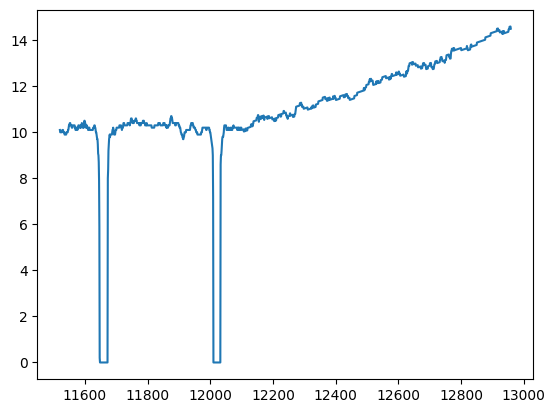



Участок: 9


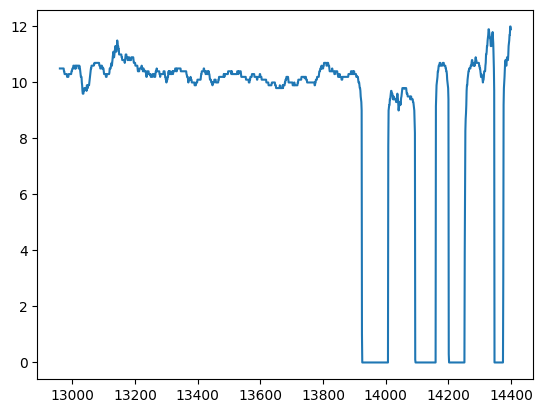

In [237]:
for  i in range(10):
  df_split[i].value.plot()
  print(f'Участок: {i}')
  plt.show()
  print('\n')

Итого 4 аномалии на 10 рядов с разной сегментацией для каждого ряда.

# Этап 1
Сегментация данных

## Визуализация

In [238]:
def plot_clustering_results(X, labels):
    """A method for graphical display of clustering results."""
    plt.plot(X[:, 0], X[:, 1], label='Time Series Data', color='blue')
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title('Clustering results using Mean Shift')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.colorbar(label='Метки кластеров')
    plt.grid()
    plt.show()

def plot_LR_results(X, labels, clustered_times, clustered_values):
    """
    A method for graphical display of
    the results of constructing a linear regression.
    """
    plt.plot(X[:, 0], X[:, 1], label='Time Series Data', color='blue')
    for cluster in np.unique(labels):
      plt.plot(clustered_times[cluster], clustered_values[cluster],
                label='Linear Trend', color='red')
    plt.legend()
    plt.grid()
    plt.show()


In [239]:
batches = []

Участок: 0


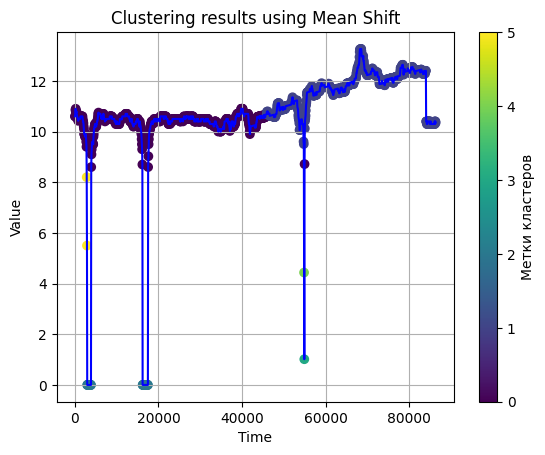

[0 0 0 ... 1 1 1]


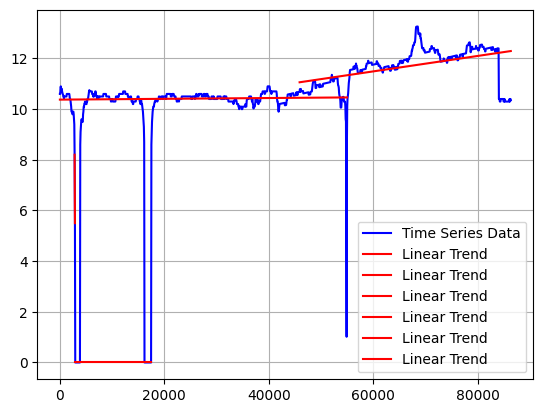



Участок: 1


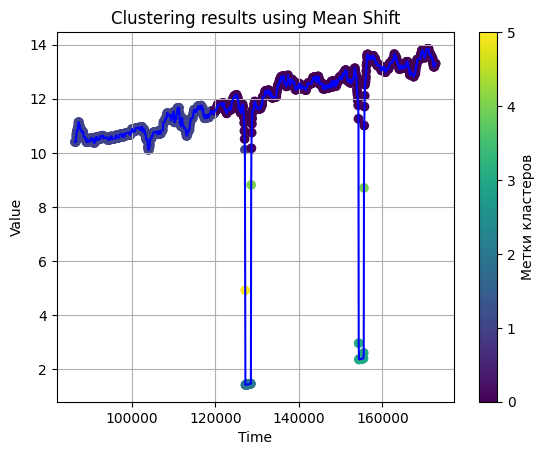

[1 1 1 ... 0 0 0]


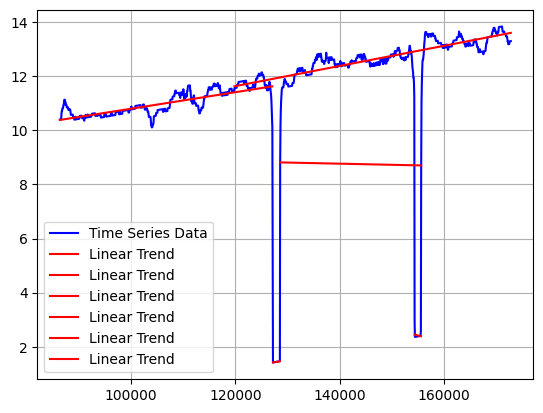



Участок: 2


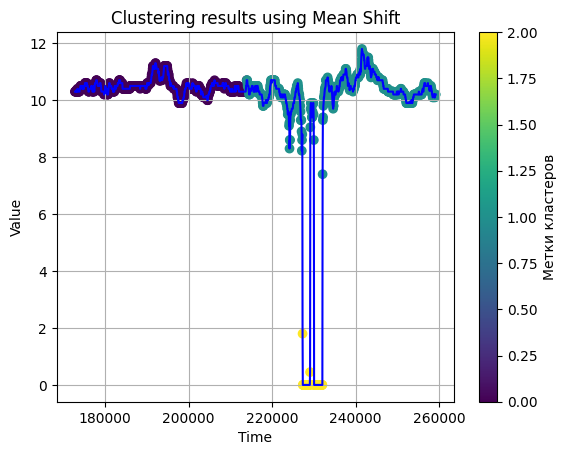

[0 0 0 ... 1 1 1]


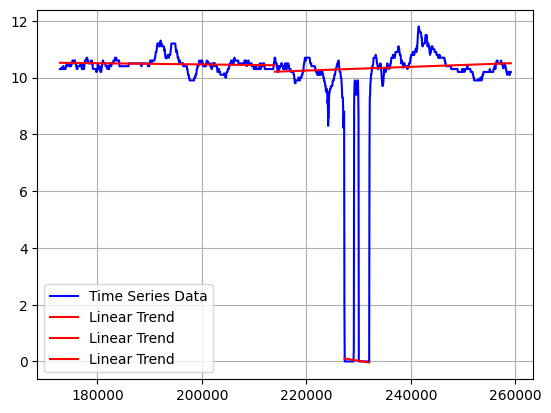



Участок: 3


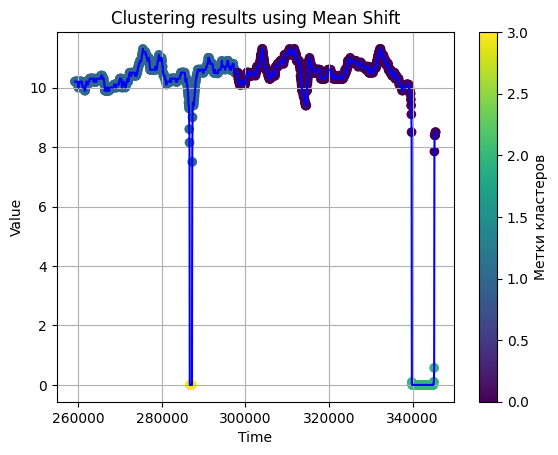

[1 1 1 ... 0 0 0]


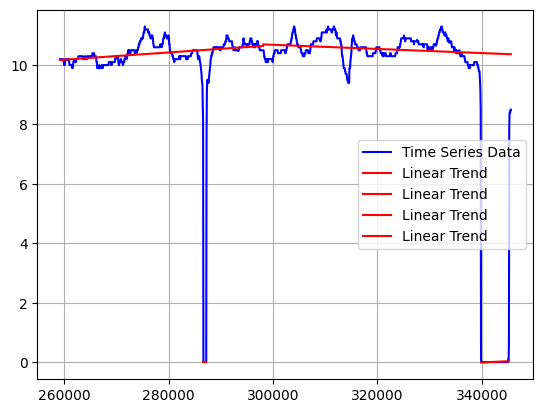



Участок: 4


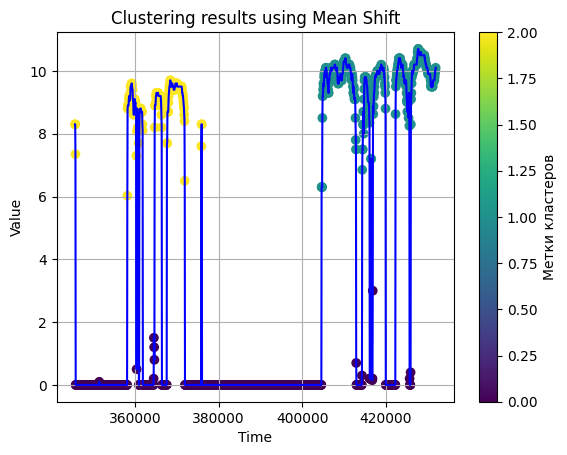

[2 2 2 ... 1 1 1]


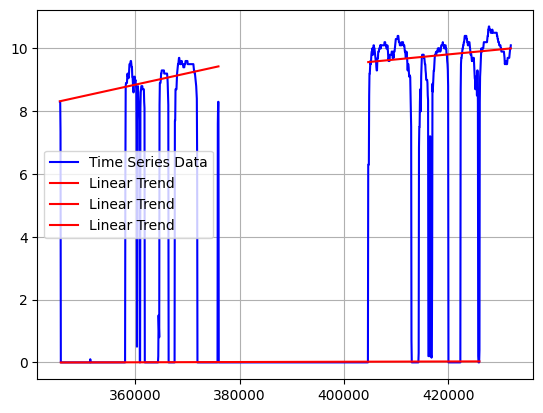



Участок: 5


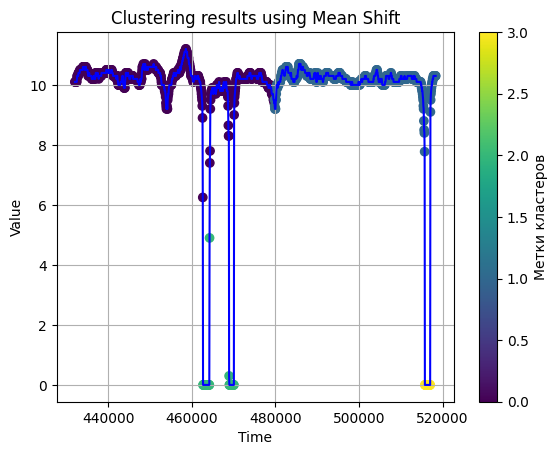

[0 0 0 ... 1 1 1]


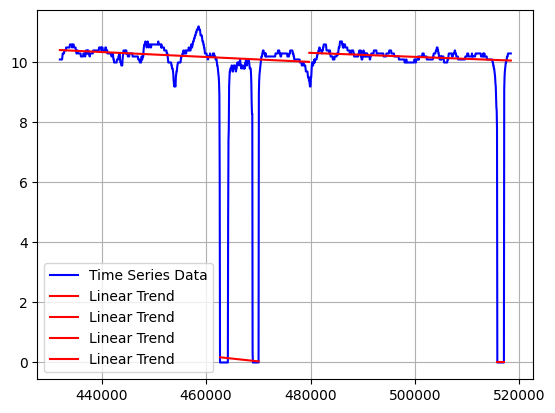



Участок: 6


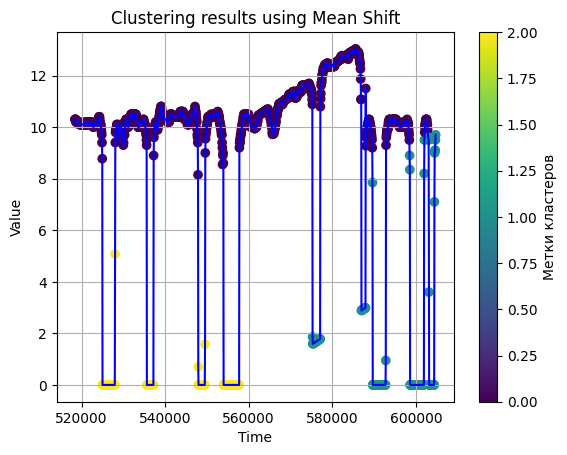

[0 0 0 ... 1 1 1]


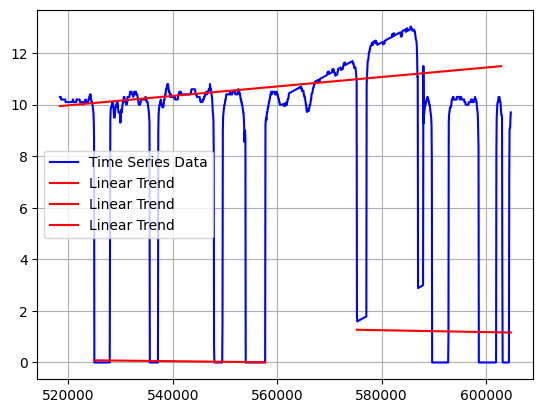



Участок: 7


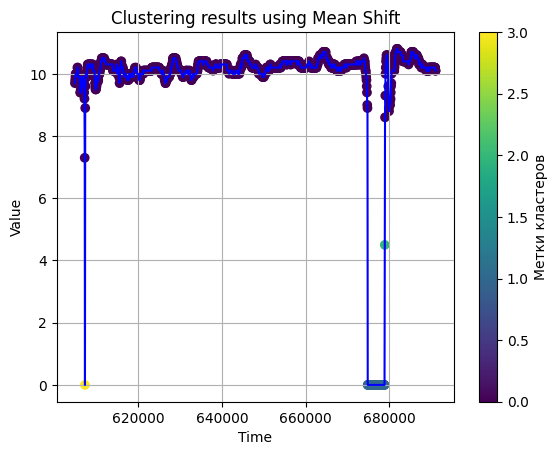

[0 0 0 ... 0 0 0]


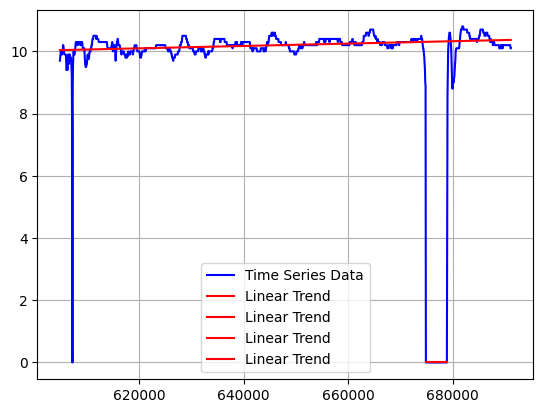



Участок: 8


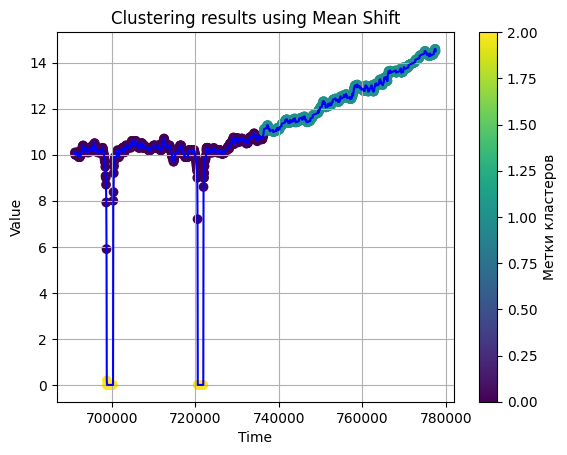

[0 0 0 ... 1 1 1]


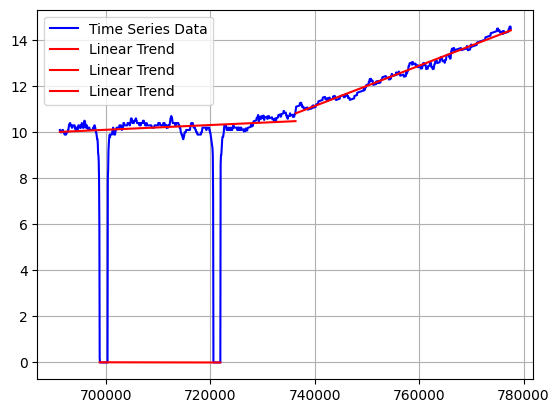



Участок: 9


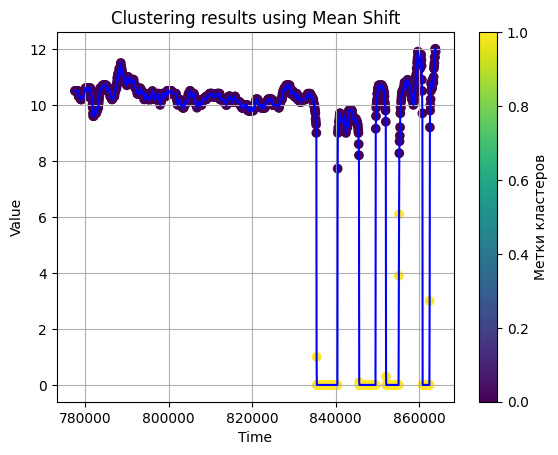

[0 0 0 ... 0 0 0]


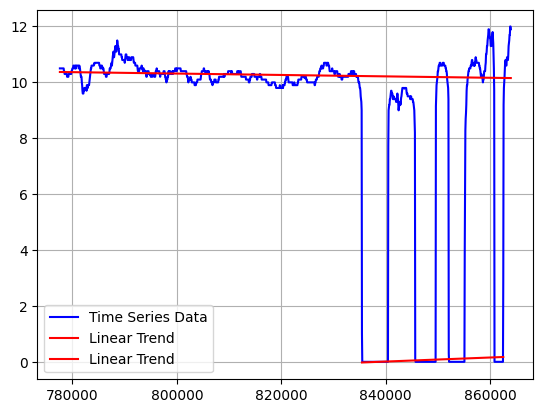



CPU times: user 1min 59s, sys: 2.71 s, total: 2min 2s
Wall time: 2min 11s


In [240]:
%%time
for i in range(10):
    print(f'Участок: {i}')
    data, cluster_labels, clustered_times, clustered_values, clustered_cofs, clustered_intercepts = model.fit_mean_shift(df_split[i])

    plot_clustering_results(data, cluster_labels)
    plot_LR_results(data, cluster_labels, clustered_times, clustered_values)
    plt.show()

    print('\n')

    batches.append((data, cluster_labels, clustered_times, clustered_values, clustered_cofs, clustered_intercepts))

## Проверка качества кластеризации

In [ ]:
!pip install tslearn

In [241]:
from tslearn.clustering import silhouette_score

In [242]:
sum_silhouette = 0;
for i in range(10):
  sum_silhouette += silhouette_score(batches[i][0], batches[i][1], metric="dtw")

In [243]:
print("Average silhouette: ", sum_silhouette/10)

Average silhouette:  -0.0019341361506146932


Среднее качество, визуально кластеризация проходит неплохо.

## Фильтрация кластеров

Теперь нужно отфильтровать редкие кластеры и кластеры у еоторых среднее значение примерно равно 0. Они не нужны для работы алгоритма

In [244]:
def filtered_clusters(data):
    # 5% от общего количества наблюдений
    alpha = 0.05
    threshold_quantity = alpha * len(data[i][1])
    unique_values, counts = np.unique(data[i][1], return_counts=True)
    filtered_numbers = unique_values[counts > threshold_quantity]

    # Отсеиваем те кластеры, у которых среднее ~ 0
    threshold_mean = 0.15
    clusters_means = np.array([np.mean(cluster) for cluster in data[i][3]])
    filtered_means = (clusters_means > threshold_mean).nonzero()

    return np.intersect1d(filtered_means, filtered_numbers)

In [245]:
filtered_clusters_ids = dict()
for i in range(10):
    filtered_clusters_ids[i] = filtered_clusters(batches)

In [246]:
filtered_clusters_ids

{0: array([0, 1]),
 1: array([0, 1]),
 2: array([0, 1]),
 3: array([0, 1]),
 4: array([1, 2]),
 5: array([0, 1]),
 6: array([0, 1]),
 7: array([0]),
 8: array([0, 1]),
 9: array([0])}

Отобразим на графиках эти участки

Участок: 0
[0 1]


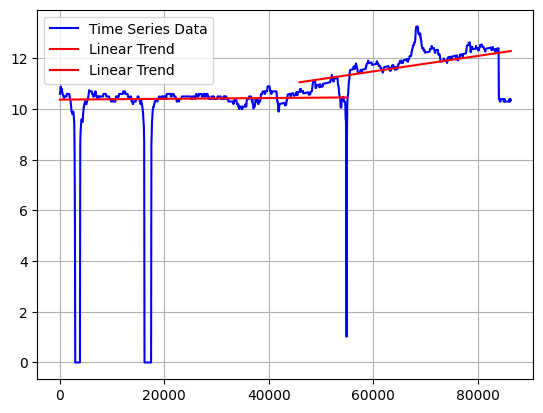



Участок: 1
[0 1]


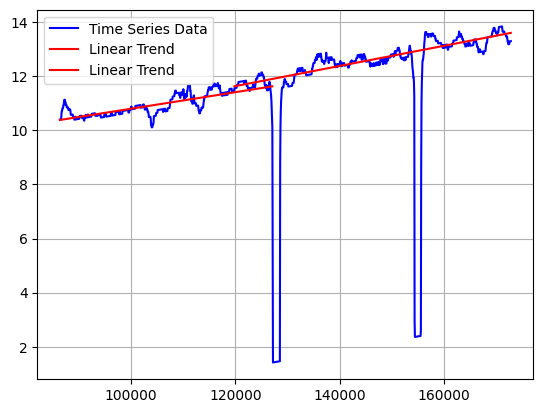



Участок: 2
[0 1]


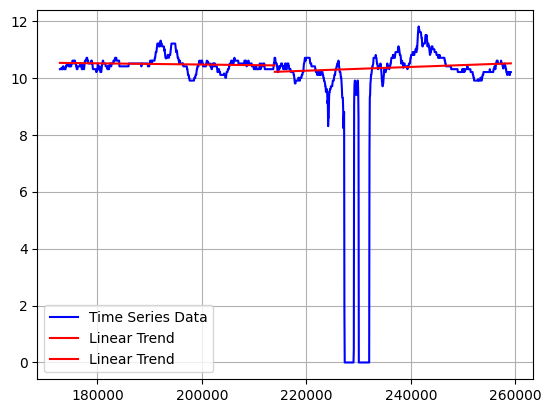



Участок: 3
[0 1]


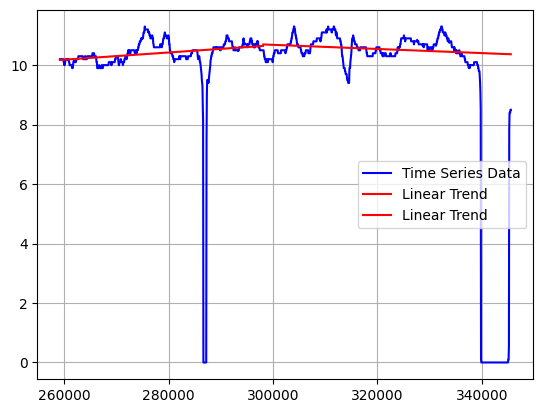



Участок: 4
[1 2]


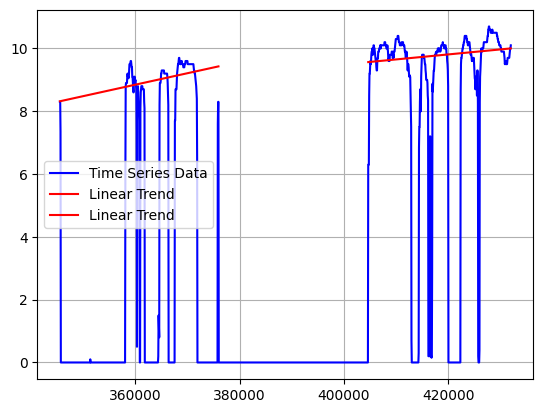



Участок: 5
[0 1]


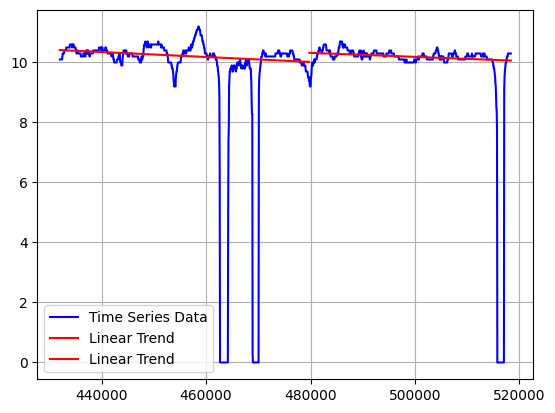



Участок: 6
[0 1]


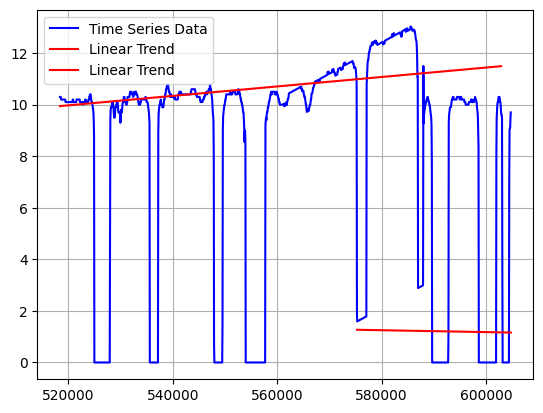



Участок: 7
[0]


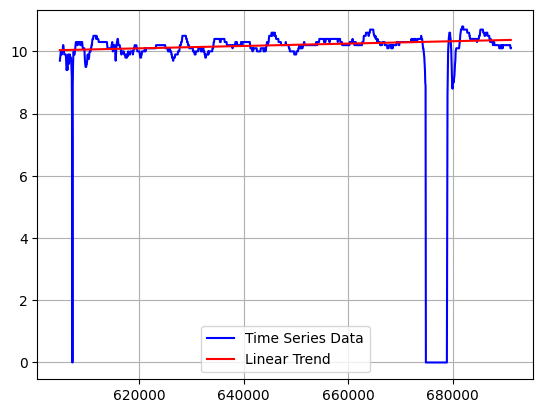



Участок: 8
[0 1]


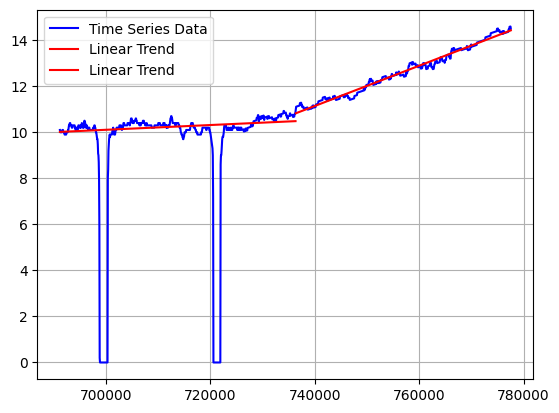



Участок: 9
[0]


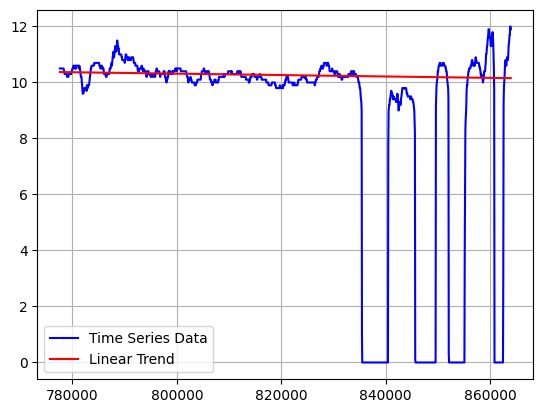

In [248]:
for i in range(10):
    print(f'Участок: {i}')
    plot_LR_results(batches[i][0], filtered_clusters_ids[i], batches[i][2], batches[i][3])
    print('\n')


Добавлены аномалии к ряду 0,1,6,8
Участок 4 интересен тем, что на нем не малый наклог ЛР. Вероятнее всего будет отмечен моделью как аномалия.

## Разметка экспертом
Далее эксперт, по средствам API, размечает какие наклоны ЛР по его мнению аномальные. Его разметка:

In [296]:
# 1 - аномалия, 0 - норма
filtered_batch_labels = {
    0: [0, 1],
    1: [1, 1],
    2: [0, 0],
    3: [0, 0],
    4: [0, 0],
    5: [0, 0],
    6: [1, 0],
    7: [0],
    8: [0, 1],
    9: [0],
}

In [261]:
filtered_clusters_ids

{0: array([0, 1]),
 1: array([0, 1]),
 2: array([0, 1]),
 3: array([0, 1]),
 4: array([1, 2]),
 5: array([0, 1]),
 6: array([0, 1]),
 7: array([0]),
 8: array([0, 1]),
 9: array([0])}

In [262]:
# Выходные переменные модели
filtered_batch_labels

{0: [0, 1],
 1: [1, 1],
 2: [0, 0],
 3: [0, 0],
 4: [0, 0],
 5: [0, 0],
 6: [1, 0],
 7: [0],
 8: [0, 1],
 9: [0]}

In [263]:
# Входные переменные модели
filtered_slopes = dict()

for index, _ in filtered_clusters_ids.items():
    filtered_slopes[index] = np.array(batches[index][4])[filtered_clusters_ids[index]]


In [264]:
filtered_slopes

{0: array([1.57799476e-06, 3.04829863e-05]),
 1: array([3.73098303e-05, 3.05648150e-05]),
 2: array([-2.13560979e-06,  6.59172028e-06]),
 3: array([-6.95897109e-06,  1.21646868e-05]),
 4: array([1.59433310e-05, 3.65847489e-05]),
 5: array([-8.24614783e-06, -6.67729538e-06]),
 6: array([ 1.8327543e-05, -3.6666666e-06]),
 7: array([3.8060058e-06]),
 8: array([1.03370068e-05, 8.75158197e-05]),
 9: array([-2.51463139e-06])}

# Этап 2
Детекция аномалий с использованием k-Fold валидации

In [265]:
import itertools

In [266]:
from sklearn.model_selection import KFold

In [267]:
#train val
X_train_validate = list(filtered_slopes.values())[:int(len(filtered_slopes.values())*0.8)]
y_train_validate = list(filtered_batch_labels.values())[:int(len(filtered_slopes.values())*0.8)]

# test
X_test = list(filtered_slopes.values())[int(len(filtered_slopes.values())*0.8):]
y_test = list(filtered_batch_labels.values())[int(len(filtered_slopes.values())*0.8):]

In [268]:
kf = KFold(n_splits=4)

In [269]:
kf.get_n_splits(X_train_validate)

4

In [274]:
from sklearn.metrics import f1_score

f1_scores = []

for train_index, val_index in kf.split(X_train_validate):

    # Входная переменная
    x_train = np.array(list(itertools.chain.from_iterable([X_train_validate[x] for x in train_index])))
    x_val = np.array(list(itertools.chain.from_iterable([X_train_validate[x] for x in val_index])))

    # Метки данных
    y_train = np.array(list(itertools.chain.from_iterable([y_train_validate[x] for x in train_index])))
    y_val = np.array(list(itertools.chain.from_iterable([y_train_validate[x] for x in val_index])))

    # Поиск лучшего порога отсечения
    best_alpha = model.evaluate_thresholds(x_train, y_train)

    # Так как данные уже были сегментированы на этапе 1, то достаточно брать x_val наклонные ЛР
    #y_pred = model.predict(None, (batches[X_train_validate], best_alpha))
    y_pred = (x_val > best_alpha).astype(int)

    # Оценка точности
    score = f1_score(y_val, y_pred, average='micro')
    f1_scores.append(score)
    print("Train")
    print("Train index: ", train_index)
    print("Validation index: ", val_index)
    print("LR slopes: ", x_train)
    print("Train labels: ", y_train)
    print("Train pred: ", (x_train > best_alpha).astype(int))
    print("Best threshold for slopes: ", best_alpha)
    print("f1 train score: ", f1_score(y_train, (x_train > best_alpha).astype(int), average='micro'))
    print("\n")

    print("Validation")
    print("f1 val score: ", score)
    print("Labels validation: ",y_val)
    print("Labels prediction: ",y_pred)
    print("Validation slopes: ",x_val)
    print('\n\n')


Train
Train index:  [2 3 4 5 6 7]
Validation index:  [0 1]
LR slopes:  [-2.13560979e-06  6.59172028e-06 -6.95897109e-06  1.21646868e-05
  1.59433310e-05  3.65847489e-05 -8.24614783e-06 -6.67729538e-06
  1.83275430e-05 -3.66666660e-06  3.80600580e-06]
Train labels:  [0 0 0 0 0 0 0 0 1 0 0]
Train pred:  [0 1 0 1 1 1 0 0 1 0 0]
Best threshold for slopes:  5.975758642915126e-06
f1 train score:  0.6363636363636364


Validation
f1 val score:  1.0
Labels validation:  [0 1 1 1]
Labels prediction:  [0 1 1 1]
Validation slopes:  [1.57799476e-06 3.04829863e-05 3.73098303e-05 3.05648150e-05]



Train
Train index:  [0 1 4 5 6 7]
Validation index:  [2 3]
LR slopes:  [ 1.57799476e-06  3.04829863e-05  3.73098303e-05  3.05648150e-05
  1.59433310e-05  3.65847489e-05 -8.24614783e-06 -6.67729538e-06
  1.83275430e-05 -3.66666660e-06  3.80600580e-06]
Train labels:  [0 1 1 1 0 0 0 0 1 0 0]
Train pred:  [0 1 1 1 1 1 0 0 1 0 0]
Best threshold for slopes:  1.4182467754213046e-05
f1 train score:  0.8181818181818

Нужно лучше настроить поиск порогового значения

In [276]:
print("Average validation f1 score: ", sum(f1_scores)/kf.get_n_splits(X_train_validate))

Average validation f1 score:  0.875


In [281]:
X_test = list(itertools.chain.from_iterable(X_test))

In [282]:
y_test = list(itertools.chain.from_iterable(y_test))

In [287]:
X_test

[1.0337006823761243e-05, 8.751581971073435e-05, -2.5146313871344407e-06]

In [286]:
y_test

[0, 1, 0]

In [285]:
# Возьмем порог равный лучшему f1 на тренеровочной и тестовой выборке
best_alpha = 1.4182467754213046e-05

In [289]:
y_pred = (np.array(X_test) > best_alpha).astype(int)

In [291]:
y_pred

array([0, 1, 0])

In [290]:
# Оценка точности
print("Оценка f1 на тестовых данных: ",f1_score(y_test, y_pred, average='micro'))

Оценка f1 на тестовых данных:  1.0
